# Carter Sifferman - CS524 Final Project: Geometric Calibration of a Sensor Attached to a Robot Arm

## Instructions for running the notebook yourself
Activate the virtual environment: `source environments/gmsjupyter/bin/activate`

Start the jupyter notebook: `jupyter notebook`

Developed with GAMS 36.2, python 3.8.10, jupyter 4.6.3

# Problem Introduction

This project is related to a research project that I've been doing with Professors Mike Gleicher and Mohit Gupta.

Say you have a robot arm like the one shown below

<img src="ur5.jpeg" width=300 height=300 />

Question is: how should we solve this to deal with uncertainty / noise

Since we only need to do this once per sensor and it takes a while to move the robot anyway, speed is not crucial. Accuracy, precision, and robustness to noise are much more important. 

# Approach

# Formulation

<img src="teaser.jpg" width=600/>

$(\textbf{a} \cdot \textbf{A}_i\textbf{p}) + \textbf{a} \cdot (d_i*\textbf{A}_i\textbf{u}) = -c-\textbf{a}\textbf{t}_i$

# Models

## Creating Simulated Data

Before building a model, it will be helpful to generate some simulated data. While we could jump straight into using real-world data from a real robot arm with a sensor attached, using simulated data will let us test our model under "ideal" conditions with no noise. After we confirm that our model works under ideal conditions, we can test it out on real data (see section [Evaluation](#evaluation) below).

In the cell below, we define some helper functions that will help us create simulated data.

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
def gen_observation(p, u, a, d, epsilon=1e-6):
    """Generate an observation from a point looking at a plane.

    Generates an observation (distance and observation point) for a sensor at
    location p looking in the direction given by the vector u looking at the
    plane defined by a[0]x + a[1]y + a[2]z + d = 0.

    https://rosettacode.org/wiki/Find_the_intersection_of_a_line_with_a_plane#Python

    Args:
        p (3-tuple of floats): the position of the sensor (x, y, z).
        u (3-tuple of floats): the orientation of the sensor (x, y, z).
          Does not have to be a unit vector.
        a (3-tuple of floats): the equation for the line where a[0]x + a[1]y + a[2]z + d = 0.
        d (float) the d portion of the line equation.

    Returns:
        The distance and intersection point as a tuple, for example, with distance
        5.2 and intersection point (8.1, 0.3, 4):

        (5.2, (8.1, 0.3, 4)) or float('inf') if the sensor does not see the plane.

    Raises:
        ValueError: The line is undefined.
    """
    a = np.array(a)
    p = np.array(p)
    u = np.array(u)

    if(a[0] != 0):
        plane_point = np.array([-d/a[0], 0, 0])
    elif(a[1] != 0):
        plane_point = np.array([0, -d/a[1], 0])
    elif(a[2] != 0):
        plane_point = np.array([0, 0, -d/a[2]])
    else:
        raise ValueError("The plane with normal a=[0,0,0] is undefined")

    ndotu = a.dot(u)
    if abs(ndotu) < epsilon:
        return float('inf')

    w = p - plane_point
    si = -a.dot(w) / ndotu
    Psi = w + si * u + plane_point
    
    dist = np.linalg.norm(Psi - p)

    if(np.allclose((dist * u) + p, Psi)):
        return (dist, Psi)
    else:
        return float('inf')

def gen_sim_trial(transforms, p, u, a, d):
    """Generate multiple observations of the same sensor pose looking at the same plane
    
    Args:
        transforms (list of 4x4 np.arrays): list of transforms to representing motions of
          the section of the robot which the sensor is attached to. Represented in homogenous
          coordinates. Should be rigid.
        p (3-tuple of floats): the position of the sensor (x, y, z).
        u (3-tuple of floats): the orientation of the sensor (x, y, z).
        a (3-tuple of floats): the equation for the line where a[0]x + a[1]y + a[2]z + d = 0.
        d (float) the d portion of the line equation.
        
    Returns:
        (list) simulated distance measurements
    """
    
    distances = []
    for tf in transforms:
        # apply transform to p and u
        tf_p = (tf @ np.array(list(p) + [1]))[:3]
        tf_u = (tf @ np.array(list(u) + [0]))[:3]
        
        distances.append(gen_observation(tf_p, tf_u, a, d)[0])
        
    return distances

def rescale_transform(tf, scale):
    """Rescale a 4x4 homogenous transform matrix by some factor
    
    Args:
        tf (4x4 np.array or python list): homogenous transform matrix to be rescaled
        scale: amount to rescale the tf by, e.g. scale=10 will change unit from cm to mm
        
    Returns:
        (4x4 np.array) rescaled transform
        
    """
    new_tf = np.array([
        [tf[0][0], tf[0][1], tf[0][2], tf[0][3]*scale],
        [tf[1][0], tf[1][1], tf[1][2], tf[1][3]*scale],
        [tf[2][0], tf[2][1], tf[2][2], tf[2][3]*scale],
        [tf[3][0], tf[3][1], tf[3][2], tf[3][3]],
    ])

    return new_tf

def read_transforms_from_file(file_path):
    """Read in a list of 4x4 homogenous transforms from a csv file
    
    csv file should be in the format:
    Aa, Ab, Ac, Ad, Ae, Af, Ag, Ah, Ai, Aj, Ak, Al, Am, An, Ao, Ap
    
    where:
    
         |  Aa, Ab, Ac, Ad  |
    tf = |  Ae, Af, Ag, Ah  |
         |  Ai, Aj, Ak, Al  |
         |  Am, An, Ao, Ap  |
         
    Args:
        file_path: the path to the file to read transforms from
        
    Returns:
        (list of 4x4 np.array objects): transforms read from file
    """
    with open(file_path) as f:
        csvfile = csv.reader(f)

        raw_transforms = []
        for line in csvfile:
            items = []
            for item in line:
                if(item != ' '):
                    items.append(float(item))
            raw_transforms.append(np.reshape(np.array(items), (4,4)))
    
    # change unit of transforms from meters to mm (to match sensor measurents, which are in mm)
    transforms = [rescale_transform(tf, 1000) for tf in raw_transforms]
    
    return transforms

def read_measurements_from_file(file_path):
    """Read in a list of measurements from a csv file
         
    Args:
        file_path: the path to the file to read measurements from
        
    Returns:
        (list of floats): measurements read from file
    """
    with open(file_path) as f:
        csvfile = csv.reader(f)

        data = []
        for line in csvfile:
            data.append([float(x) for x in line[1:]])

        data = np.array(data)
    measurements = np.average(data, axis=1)
    
    return measurements

def split_transforms(transforms):
    """Split a list of homogenous transforms into affine A and translate t components
    
    Args:
        transforms: a list of 4x4 np.array transforms to split
        
    Returns:
        (tuple) (As (list of 3x3 np.arrays), ts (list of length 3 np.arrays)): split transforms
    """
    As = []
    ts = []
    for tf in transforms:
        As.append(
            np.array([
                [tf[0][0], tf[0][1], tf[0][2]],
                [tf[1][0], tf[1][1], tf[1][2]],
                [tf[2][0], tf[2][1], tf[2][2]]
            ])
        )
        ts.append(
            np.array([tf[0][3], tf[1][3], tf[2][3]])
        )
        
    return (As, ts)

def pp_gams(var):
    """pretty prints a variable that's been pulled from gams
    
    Args:
        var: a parameter or variable that's been pulled from gams
        
    Returns:
        string: an easily readable version of that variable
    """
    string = "("
    for x in var:
        string += " " + str(x[1]) + ","
    
    return string + " )"

## Generate the simulated sensor measurements from a set of motions
Next, read in the transforms (robot motions) that were used to run the real world trial 5. We could use some randomly generated set of transforms, but there's no reason to, and by using these, we know that the sensor won't accidentally pass through the plane, because that is impossible in the real world that the motions come from.

In [3]:
trial_5_tfs = read_transforms_from_file('data/trial_5/transforms.csv')

trial_5_As, trial_5_ts = split_transforms(trial_5_tfs)

# p, u, a, d estimates are arbitrary for simulated data. Here I just use rough estimates of
# what their true values were when I ran the real experiment
p_est = (10, 10, 170)
u_est = (-1, 0, 0)
a_est = (0, 0, 1)
d_est = 187
trial_5_sim_ms = gen_sim_trial(trial_5_tfs, p_est, u_est, a_est, d_est)

First, we write and test the models on some simulated data, just to confirm that they work in the ideal case. We move on to real-world and noisy simulated data in the "Evaluation" section below.

## Least Squares (QCP) Optimization Model - Solve for Sensor Parameters
<a id='lstsq_sensor'></a>

In [46]:
%load_ext gams_magic
%gams_cleanup -k
%gams_reset

The gams_magic extension is already loaded. To reload it, use:
  %reload_ext gams_magic


In [47]:
%%gams
sets
    dim "3D coordinate / vector dimensions",
    obs "set of observations",
    mat "entry names for a 3x3 matrix";

parameters
    m(obs) "(m)easurement observed per observation",
    big_A(obs, mat) "affine transform matrix for robot motion for the given observation",
    t(obs, dim) "translation component of robot motion for the given observation"
    a(dim) "a component of plane equation ax+d=0",
    d "d component of plane equation ax+d=0";
    
scalar d;

In [48]:
"""SETS"""
obs = [str(x) for x in list(range(1, len(trial_5_tfs)+1))] # index for observations
mat = ['Aa', 'Ab', 'Ac', 'Ad', 'Ae', 'Af', 'Ag', 'Ah', 'Ai'] # entry names for 3x3 matrix A
dim = ['x', 'y', 'z'] # 3D coordinate / vector dimensions

%gams_push obs mat dim

"""PARAMETERS"""
m = [(ob, measurement) for (ob, measurement) in zip(obs, trial_5_sim_ms)] # (m)easurement observed per observation

big_A = []
for ob in obs:
    for entry, i in zip(mat, range(len(mat))):
        big_A.append((ob, entry, trial_5_As[int(ob)-1].flatten()[i]))
        
t = []
for ob in obs:
    for dimens, i in zip(dim, range(len(dim))):
        t.append((ob, dimens, trial_5_ts[int(ob)-1][i]))
        
a = [(dimens, x) for dimens, x in zip(dim, a_est)]
d = d_est

%gams_push m big_A t a d

In [49]:
%%gams
option limrow=0, limcol=0;
option solprint=off;

variables
    p(dim) "position of sensor in 3D space",
    u(dim) "heading vector denoting orientation of sensor in 3D space (unit length)",
    loss "objective",
    loss_term(obs) "loss over one specific observation";
    
equations
    loss_fn "overall loss function (objective is to minimize)",
    def_loss_term(obs) "define one loss term at a time",
    u_unit "constrain u to be unit length";
    
loss_fn..
    loss =e= sum(obs, sqr(loss_term(obs)));

def_loss_term(obs)..
    loss_term(obs) =e=
        p("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + p("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + p("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + m(obs) * u("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + m(obs) * u("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + m(obs) * u("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + d
        + sum(dim, a(dim)*t(obs, dim));
        
u_unit..
    sum(dim, sqr(u(dim))) =e= 1;

u.l(dim) = sqrt(1/3);
    
model lstsq /loss_fn, def_loss_term, u_unit/;
solve lstsq using qcp minimizing loss;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0,52,57,QCP,CONOPT,0.005


In [8]:
%gams_pull p u
print("p", pp_gams(p))
print("u", pp_gams(u))

p ( 9.9999999550593, 9.999999998487382, 169.9999999248231, )
u ( -0.9999999998051181, -7.268655626432152e-11, 2.8610275954988265e-10, )


## Least Squares (QCP) Optimization Model - Solve for Plane Parameters
<a id='lstsq_plane'></a>

In [9]:
%gams_cleanup -k
%gams_reset

In [10]:
%%gams
sets
    dim "3D coordinate / vector dimensions",
    obs "set of observations",
    mat "entry names for a 3x3 matrix";

parameters
    m(obs) "(m)easurement observed per observation",
    big_A(obs, mat) "affine transform matrix for robot motion for the given observation",
    t(obs, dim) "translation component of robot motion for the given observation"
    p(dim) "position of sensor on robot",
    u(dim) "heading vector denoting the orientation of the sensor on the robot";

In [11]:
"""SETS"""
obs = [str(x) for x in list(range(1, len(trial_5_tfs)+1))] # index for observations
mat = ['Aa', 'Ab', 'Ac', 'Ad', 'Ae', 'Af', 'Ag', 'Ah', 'Ai'] # entry names for 3x3 matrix A
dim = ['x', 'y', 'z'] # 3D coordinate / vector dimensions

%gams_push obs mat dim

"""PARAMETERS"""
m = [(ob, measurement) for (ob, measurement) in zip(obs, trial_5_sim_ms)] # (m)easurement observed per observation

big_A = []
for ob in obs:
    for entry, i in zip(mat, range(len(mat))):
        big_A.append((ob, entry, trial_5_As[int(ob)-1].flatten()[i]))
        
t = []
for ob in obs:
    for dimens, i in zip(dim, range(len(dim))):
        t.append((ob, dimens, trial_5_ts[int(ob)-1][i]))
        
p = [(dimens, x) for dimens, x in zip(dim, p_est)]
u = [(dimens, x) for dimens, x in zip(dim, u_est)]

%gams_push m big_A t p u

In [12]:
%%gams
option limrow=0, limcol=0;
option solprint=off;

variables
    a(dim) "a component of plane equation ax+d=0",
    d "d component of plane equation ax+d=0",
    loss "objective",
    loss_term(obs) "loss over one specific observation";
    
equations
    loss_fn "overall loss function (objective is to minimize)",
    def_loss_term(obs) "define one loss term at a time"
    a_unit "constrain a to be unit length";
    
loss_fn..
    loss =e= sum(obs, sqr(loss_term(obs)));

def_loss_term(obs)..
    loss_term(obs) =e=
        p("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + p("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + p("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + m(obs) * u("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + m(obs) * u("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + m(obs) * u("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + d
        + sum(dim, a(dim)*t(obs, dim));

a_unit..
    sum(dim, sqr(a(dim))) =e= 1;
    
a.l(dim) = sqrt(1/3);

model lstsq /loss_fn, def_loss_term, a_unit/;
solve lstsq using qcp minimizing loss;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0,52,55,QCP,CONOPT,0.002


In [13]:
%gams_pull a d
print("a", pp_gams(a))
print("d", d[0])

a ( 5.077995606014033e-19, -9.858388584834043e-18, 1.0000000168488792, )
d (187.00000315074044, 5e-324, -inf, inf, 1.0)


<a id='bilinear'></a>
## Bilinear (NLP) Optimization Model - Solve for Plane and Sensor Parameters Simultaneously

In [51]:
%gams_cleanup -k
%gams_reset

Push data to GAMS

In [52]:
%%gams
sets
    dim "3D coordinate / vector dimensions",
    obs "set of observations",
    mat "entry names for a 3x3 matrix";

parameters
    m(obs) "(m)easurement observed per observation",
    big_A(obs, mat) "affine transform matrix for robot motion for the given observation",
    t(obs, dim) "translation component of robot motion for the given observation";

In [53]:
"""SETS"""
obs = [str(x) for x in list(range(1, len(trial_5_tfs)+1))] # index for observations
mat = ['Aa', 'Ab', 'Ac', 'Ad', 'Ae', 'Af', 'Ag', 'Ah', 'Ai'] # entry names for 3x3 matrix A
dim = ['x', 'y', 'z'] # 3D coordinate / vector dimensions

%gams_push obs mat dim

"""PARAMETERS"""
m = [(ob, measurement) for (ob, measurement) in zip(obs, trial_5_sim_ms)] # (m)easurement observed per observation

big_A = []
for ob in obs:
    for entry, i in zip(mat, range(len(mat))):
        big_A.append((ob, entry, trial_5_As[int(ob)-1].flatten()[i]))
        
t = []
for ob in obs:
    for dimens, i in zip(dim, range(len(dim))):
        t.append((ob, dimens, trial_5_ts[int(ob)-1][i]))
        
%gams_push m big_A t

In [54]:
%%gams
option limrow=0, limcol=0;
option solprint=off;

variables
    p(dim) "position of sensor in 3D space",
    u(dim) "heading vector denoting orientation of sensor in 3D space (unit length)",
    a(dim) "a component of plane equation ax+d=0",
    d "d component of plane equation ax+d=0",
    loss "objective",
    loss_term(obs) "loss over one specific observation";

equations
    loss_fn "overall loss function (objective is to minimize)",
    def_loss_term(obs) "define one loss term at a time",
    u_unit "constrain u to be a unit vector",
    a_unit "constrain a to be a unit vector";

loss_fn..
    loss =e= sum(obs, sqr(loss_term(obs)));

def_loss_term(obs)..
    loss_term(obs) =e=
        p("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + p("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + p("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + m(obs) * u("x") * (a("x")*big_A(obs, "Aa") + a("y")*big_A(obs, "Ad") + a("z")*big_A(obs, "Ag"))
        + m(obs) * u("y") * (a("x")*big_A(obs, "Ab") + a("y")*big_A(obs, "Ae") + a("z")*big_A(obs, "Ah"))
        + m(obs) * u("z") * (a("x")*big_A(obs, "Ac") + a("y")*big_A(obs, "Af") + a("z")*big_A(obs, "Ai"))
        + d
        + sum(dim, a(dim)*t(obs, dim));

u_unit..
    sqrt(sum(dim, sqr(u(dim)))) =e= 1;

a_unit..
    sqrt(sum(dim, sqr(a(dim)))) =e= 1;

* can fix a and d here

p.l("x") = 15;
p.l("y") = 10;
p.l("z") = 170;
u.l("x") = -1;
u.l("y") = 0;
u.l("z") = 0;
a.l("x") = 0;
a.l("y") = 0;
a.l("z") = 1;
d.l = 187;

model lstsq /all/;
solve lstsq using nlp minimizing loss;
display p.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0,53,61,NLP,CONOPT,0.015


In [18]:
%gams_pull p loss u a d loss_term
print("p", p)
print("u", u)
print("a", a)
print("d", d)
# print("loss", loss)
# print("loss term", loss_term)

p [('x', 10.00000002056135, 5e-324, -inf, inf, 1.0), ('y', 10.000000007579754, 5e-324, -inf, inf, 1.0), ('z', 170.00000009588013, 1.132690821526238e-11, -inf, inf, 1.0)]
u [('x', -1.0000000002410905, 0.0, -inf, inf, 1.0), ('y', 9.39524010852831e-11, -2.1371354181899987e-09, -inf, inf, 1.0), ('z', -3.798504929524227e-10, 4.487330463066106e-09, -inf, inf, 1.0)]
a [('x', 8.850161169310243e-11, -2.1383507292460108e-08, -inf, inf, 1.0), ('y', 9.726327430859958e-12, 2.740366505866235e-09, -inf, inf, 1.0), ('z', 1.0000000000296747, 0.0, -inf, inf, 1.0)]
d [(186.99999997149033, -3.291233952040784e-11, -inf, inf, 1.0)]


## Note: Alternating Least Squares (QCP) Optimization Model

The bilinear case of our model has something special about it: if you hold any one set of unknowns (either the plane parameters or sensor parameters) constant, it becomes a least squares problem - either the [unknown plane version](#lstsq_plane) or [unknown sensor version](#lstsq_sensor) described above. We could exploit this, and alternate between the two least squares problems, using the solution from one model to fix the parameters in the next. This way, we would never have to touch NLP! (Although, in a way, we would still be doing NLP, just more manually, using two QCPs, I think)

At least, in theory. I messed around this for a while and never got it working. I haven't found great resources for this online - most are talking about the matrix factorization problem, which may be equivalent, but reading about it doesn't help. I think the problem is that our problems aren't plain least squares because of the unit vector constraints, so they're not gauranteed to converge when you alternate.

I've removed my work since this document is already long and there are more interesting things to focus on. Plus, [the NLP model above](#bilinear) seems to be pretty robust, and fast enough, since we're never going to be solving problems with more than ~50 terms, and speed is not crucial.

# Evaluation: Sensitivity Analysis and Cross Validation
<a id='evaluation'></a>

We evaluate our models' performance in two ways:
1. Use simulated data for which we know the ground truth, and test for solution accuracy given some known noise model for the sensor measurements. This may not translate to the real world, in which the noise model for the sensor is not exactly known.
2. Use real data gathered from a sensor attached to a robot, and test for solution *precision*, not accuracy, since ground truth is not exactly known. Find the "cross-trial" precision by using all measurements from two separate trials which have different plane positions and motions, but the same sensor position, and comparing their solved position. In reality, this position should be the same for both trials.

Define some helper functions to help us with evaluation:

In [19]:
def gams_to_list(gams_param):
    """Convert a gams parameter's .l values to a python list
    
    Args:
        gams_param: gams style parameter to be converted
        
    Returns:
        (list): the parameter's .l values as a list
    """
    
    return [x[1] for x in gams_param]

def l2_distance(p1, p2):
    """Get l2 distance between point p1 and point p2
    
    Args:
        p1: first point
        p2: second point
        
    Returns:
        (float): l2 distance between point 1 and point 2
    """
    return np.linalg.norm(np.array(p1) - np.array(p2))

def angle_between(v1, v2):
    """Get angle between two vectors v1 and v2
    
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return angle

## Evaluating Models via Sensitivity Analysis on Simulated Data

Now we need to re-run some previous cells to get the correct gams model loaded up. To avoid copy-pasting code (because I can't figure out how to put gams code inside a function) we do this programatically with some JavaScript jupyter notebook magic:

In [22]:
%%javascript
Jupyter.notebook.execute_cells([8, 9, 10, 11]) // run cells 8, 9, 10, 11

<IPython.core.display.Javascript object>

This loop runs the least squares optimization 1000 times, with different noise in the data ($\textbf{a}$, $d$, and $m_i$) each time. We then record the error in the solution and plot the distribution of error for both the linear least squares (QCP) problem, and the bilinear (NLP) problem.

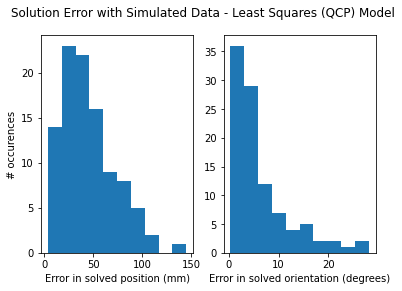

Average error in solved sensor position: 45.149248663885494 mm
Average error in solved sensor orientation: 6.369926449011052  degrees


In [27]:
np.random.seed(0) # for re-producability

p_errors = []
u_errors = []
for _ in range(100):
    d = d_est + np.random.normal(0, 5) # add noise to the d plane parameter estimate
    
    rand_a = [x + np.random.normal(0, 0.05) for x in a_est] # add noise to the a plane param. est.
    a_noisy = np.array(rand_a) / np.linalg.norm(np.array(rand_a)) # normalize the random a parameter
    a = [(dimens, x) for dimens, x in zip(dim, a_noisy)]
    
    trial_5_sim_ms_noisy = [x + np.random.normal(0, 5) for x in trial_5_sim_ms] # add noise to measurements
    m = [(ob, measurement) for (ob, measurement) in zip(obs, trial_5_sim_ms_noisy)]
    
    %gams_push m a d
    %gams model lstsq /all/;
    %gams solve lstsq using qcp minimizing loss;
    %gams_pull p u
    p_errors.append(l2_distance(gams_to_list(p), p_est))
    u_errors.append(angle_between(gams_to_list(u), u_est))

fig, ax = plt.subplots(1, 2)
ax[0].hist(p_errors)
ax[0].set_xlabel("Error in solved position (mm)")
ax[0].set_ylabel("# occurences")
ax[1].hist([np.degrees(x) for x in u_errors])
ax[1].set_xlabel("Error in solved orientation (degrees)")
fig.suptitle("Solution Error with Simulated Data - Least Squares (QCP) Model")
plt.show()

print("Average error in solved sensor position:", sum(p_errors) / len(p_errors), "mm")
print("Average error in solved sensor orientation:", np.degrees(sum(u_errors) / len(u_errors)), " degrees")

In [28]:
%%javascript
Jupyter.notebook.execute_cells([20, 22, 23, 24]) // run cells 20, 22, 23, 24

<IPython.core.display.Javascript object>

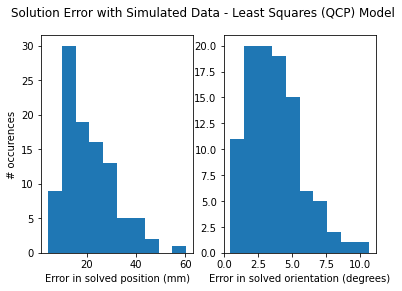

Average error in solved sensor position: 20.805282417560747 mm
Average error in solved sensor orientation: 3.6697371956282376  degrees


In [33]:
np.random.seed(0) # for re-producability

p_errors = []
u_errors = []
for _ in range(100):
    d_gms_est = d_est + np.random.normal(0, 5) # add noise to the d plane parameter estimate
    
    rand_a = [x + np.random.normal(0, 0.05) for x in a_est] # add noise to the a plane param. est.
    a_noisy = np.array(rand_a) / np.linalg.norm(np.array(rand_a)) # normalize the random a parameter
    a_x_est, a_y_est, a_z_est = a_noisy
    
    trial_5_sim_ms_noisy = [x + np.random.normal(0, 5) for x in trial_5_sim_ms] # add noise to measurements
    m = [(ob, measurement) for (ob, measurement) in zip(obs, trial_5_sim_ms_noisy)]
    
    %gams scalar a_x_est, a_y_est, a_z_est, d_gms_est;
    
    %gams_push m a_x_est a_y_est a_z_est d_gms_est
    
    %gams a.l("x") = a_x_est;
    %gams a.l("y") = a_y_est;
    %gams a.l("z") = a_z_est;
    %gams d.l = d_gms_est;
    %gams model lstsq /all/;
    %gams solve lstsq using nlp minimizing loss;
    
    %gams_pull p u
    
    p_errors.append(l2_distance(gams_to_list(p), p_est))
    u_errors.append(angle_between(gams_to_list(u), u_est))

fig, ax = plt.subplots(1, 2)
ax[0].hist(p_errors)
ax[0].set_xlabel("Error in solved position (mm)")
ax[0].set_ylabel("# occurences")
ax[1].hist([np.degrees(x) for x in u_errors])
ax[1].set_xlabel("Error in solved orientation (degrees)")
fig.suptitle("Solution Error with Simulated Data - Bilinear (NLP) Model")
plt.show()

print("Average error in solved sensor position:", sum(p_errors) / len(p_errors), "mm")
print("Average error in solved sensor orientation:", np.degrees(sum(u_errors) / len(u_errors)), " degrees")

The bilinear NLP model seems to be less sensitive to noise by a significant amount - the average error is half as much as the least squares QCP model. This is not surprising - because the bilinear NLP model is able to adjust the plane parameters, it is less thrown off by variations in the plane estimates. Meanwhile, the linear model has to trust the plane parameters that we give it. The thing we give up when we use the NLP model is a guarantee of finding a global minima, and, theoretically, some speed.

## Evaluating Models via Cross Validation with Real Data

Sensitivity analysis on simulated data will give us a good idea of how sensitive our solution is to noise, but it assumes some noise model (we used zero-centered gaussian above) which is probably not true to life. To assess how well our models work to enable calibration in the real world, we can perform cross-validation.

We have data from four real world trials, which use four sets of motions, two different planes, and two sensor positions. We are able to solve for all four trials, using both methods, and compare the solved sensor positions. In reality, between certain pairs of trials, the sensor did not move, so we can use the distance between the solved position of those trials as a measure of the precision of our solution.

Ideally, we would have a lot more than two sample points. I'm working on automating robot motions so that we can more easily gather more data, but that data is not available yet.

In [45]:
%%javascript
Jupyter.notebook.execute_cells([8, 9, 10, 11]) // run cells 8, 9, 10, 11

<IPython.core.display.Javascript object>

In [ ]:
linear_ps = []
linear_us = []
bilinear_ps = []
bilinear_us = []

for trial_name in ['trial_5', 'trial_6', 'trial_7', 'trial_8']:
    transforms = read_transforms_from_file(f'data/{trial_name}/transforms.csv')
    As, ts = split_transforms(transforms)
    measurements = read_measurements_from_file(f'data/{trial_name}/measurements.csv')
    
    m = [(ob, measurement) for (ob, measurement) in zip(obs, measurements)]

    big_A = []
    for ob in obs:
        for entry, i in zip(mat, range(len(mat))):
            big_A.append((ob, entry, As[int(ob)-1].flatten()[i]))

    t = []
    for ob in obs:
        for dimens, i in zip(dim, range(len(dim))):
            t.append((ob, dimens, ts[int(ob)-1][i]))
            
    # set a and d plane parameter estimates depending on the trial
    if (trial_name == 'trial_5' or trial_name == 'trial_8'):
        a_est = (0, 0, 1)
        d_est = 187
    elif (trial_name == 'trial_6' or trial_name == 'trial_7'):
        a_est = (1, 0, 0)
        d_est = -900
        
    a = [(dimens, x) for dimens, x in zip(dim, a_est)]
    d = d_est
    
    %gams_push big_A t a d m
    %gams model lstsq /all/;
    %gams solve lstsq using qcp minimizing loss;
    %gams_pull p u
    
    linear_ps.append(p)
    linear_us.append(u)

In [50]:
%%javascript
Jupyter.notebook.execute_cells([20, 22, 23, 24]) // run cells 8, 9, 10, 11

<IPython.core.display.Javascript object>

In [62]:
for trial_name in ['trial_5', 'trial_6', 'trial_7', 'trial_8']:
    transforms = read_transforms_from_file(f'data/{trial_name}/transforms.csv')
    As, ts = split_transforms(transforms)
    measurements = read_measurements_from_file(f'data/{trial_name}/measurements.csv')
    
    m = [(ob, measurement) for (ob, measurement) in zip(obs, measurements)]

    big_A = []
    for ob in obs:
        for entry, i in zip(mat, range(len(mat))):
            big_A.append((ob, entry, As[int(ob)-1].flatten()[i]))

    t = []
    for ob in obs:
        for dimens, i in zip(dim, range(len(dim))):
            t.append((ob, dimens, ts[int(ob)-1][i]))
            
    # set a and d plane parameter estimates depending on the trial
    if (trial_name == 'trial_5' or trial_name == 'trial_8'):
        a_est = (0, 0, 1)
        d_est = 187
    elif (trial_name == 'trial_6' or trial_name == 'trial_7'):
        a_est = (1, 0, 0)
        d_est = -900
        
    a_x_est, a_y_est, a_z_est = a_est
    d_gms_est = d_est
    
    %gams scalar a_x_est, a_y_est, a_z_est, d_gms_est;
    
    %gams_push big_A t m a_x_est a_y_est a_z_est d_gms_est
    
    %gams a.l("x") = a_x_est;
    %gams a.l("y") = a_y_est;
    %gams a.l("z") = a_z_est;
    %gams d.l = d_gms_est;    
    %gams model lstsq /all/;
    %gams solve lstsq using nlp minimizing loss;
    %gams_pull p u
    
    bilinear_ps.append(p)
    bilinear_us.append(u)
    
print("-----QCP Cross-Validated Errors-----")
print("Trial 5 vs. Trial 8:", f"{l2_distance(gams_to_list(linear_ps[0]), gams_to_list(linear_ps[3])):.2f}mm / {np.degrees(angle_between(gams_to_list(linear_us[0]), gams_to_list(linear_us[3]))):.2f} degrees")
print("Trial 6 vs. Trial 7:", f"{l2_distance(gams_to_list(linear_ps[1]), gams_to_list(linear_ps[2])):.2f}mm / {np.degrees(angle_between(gams_to_list(linear_us[1]), gams_to_list(linear_us[2]))):.2f} degrees")
print()

print("-----NLP Cross-Validated Errors-----")
print("Trial 5 vs. Trial 8:", f"{l2_distance(gams_to_list(bilinear_ps[0]), gams_to_list(bilinear_ps[3])):.2f}mm / {np.degrees(angle_between(gams_to_list(bilinear_us[0]), gams_to_list(bilinear_us[3]))):.2f} degrees")
print("Trial 6 vs. Trial 7:", f"{l2_distance(gams_to_list(bilinear_ps[1]), gams_to_list(bilinear_ps[2])):.2f}mm / {np.degrees(angle_between(gams_to_list(bilinear_us[1]), gams_to_list(bilinear_us[2]))):.2f} degrees")
print()

-----QCP Cross-Validated Errors-----
Trial 5 vs. Trial 8: 48.64mm / 1.64 degrees
Trial 6 vs. Trial 7: 49.06mm / 1.44 degrees

-----NLP Cross-Validated Errors-----
Trial 5 vs. Trial 8: 61.66mm / 1.92 degrees
Trial 6 vs. Trial 7: 46.99mm / 1.70 degrees



On our real-world cross validation test, the NLP model actually performs slightly worse, which is not what I expected.

One easy explanation is that our sample size for cross validation is too small, and the QCP model is getting lucky. Maybe given enough samples, the NLP model would come out on top. Another explanation is that the estimates for the plane, which the QCP model trusts entirely and has no ability to modify, are pretty good. Maybe the NLP model is being too liberal with it's ability to move the plane. I describe a way to address this in [Future Work](#future_work).

# Conclusion

<a id='future_work'></a>
## Future Work
Some ideas for future directions for the project, modeling-wise:
- **Punish the NLP model for adjusting plane parameters:** we could create some variable which tracks how much the plane parameters have moved from the initial estimate, and add them to the objective function, with some weight. We could then try many different values of that weighting variable to find the sweet spot between the bilinear and least squares model which allows the plane to move, but not too much.
- **Experiment with different loss functions:** we only used an l2-norm loss function in our models, but other loss functions, such as the huber or l1-norm may give better results, especially on real-world data which may have strong outliers, which the l2-norm is sensitive to.
- **Eliminate the need for initial estimates:** without any initial estimates, the bilinear NLP model fails to solve. We could, however, try searching many random initial estimates, and we might eventually hit one which does solve. If we hit many that solve, we can take the one with the lowest loss. This is made possible by the fact that we have a finite search space: the sensor can only be so far out on the robot.

## Takeaways

TODOTODOTODO

Since this is part of an ongoing project, I'd love your feedback on ways to improve the solving, with a focus on accuracy over speed. If you're not able to on canvas you can shoot me an email if you have the chance, sifferman@wisc.edu.

Thanks for a good semester!